# Preprocessing

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import librosa as lr
from tqdm import tqdm
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [31]:
data_folder = "/Users/harsh/Downloads/Audio_1/LibriSpeech/"

In [33]:
x=np.array((),dtype='int32')
y=np.array((),dtype='int32')
file = open(data_folder+'SPEAKERS.txt','r')
for i in range(12):
    file.readline()
line = file.readline().split('|')
Dict = {'F':0,'M':1}
while (len(line)>1):
    package = line[2].strip()
    if(package=='dev-clean'):
        y = np.append(y,Dict.get(line[1].strip()))
        x = np.append(x,int(line[0].strip()))
    line = file.readline().split('|')
file.close() 
data = {}
for i in range(len(x)):
    data[int(x[i])] = np.array(())

In [63]:
#y,x

(array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 0.]),
 array([  84.,  174.,  251.,  422.,  652.,  777., 1272., 1462., 1673.,
        1919., 1988., 1993., 2035., 2078., 2086., 2277., 2412., 2428.,
        2803., 2902., 3000., 3081., 3170., 3536., 3576., 3752., 3853.,
        5338., 5536., 5694., 5895., 6241., 6295., 6313., 6319., 6345.,
        7850., 7976., 8297., 8842.]))

In [34]:
dict_y = dict(zip(x,y))

In [ ]:
# dict_y

In [ ]:
t_j = 0
j = 0
for subdirs,dirs,files in os.walk(data_folder+'dev-clean'):
    t_j+=1
for subdirs,dirs,files in os.walk(data_folder+'dev-clean'):
    for file in files:
        if file.endswith('.flac'):
            audio,sf = lr.load(subdirs+'/'+file)
            data[int(subdirs.split('/')[-2])] = np.append(data[int(subdirs.split('/')[-2])],audio)    
    j+=1
#     print(float(j)/t_j*100)

In [8]:
#plt.plot(np.arange(0,len(data[x[1]]))/sf,data[x[1]])

## Mel Filterbanks (not MFCC)

In [66]:
seg = 550      #0.025*sf
log_en = np.zeros((100,26))
for i in range(len(x)):
    l = 0
    ctr = 0
    while(l<len(data.get(x[i]))):
        pow_spec = (np.abs(np.fft.fftshift(np.fft.fft(data.get(x[i])[l:l+seg],512))[:257])**2)/seg
        mfb = lr.filters.mel(sr=22050,n_fft=512,n_mels=26)
        energy = np.matmul(mfb,pow_spec)
        energy = np.where(energy == 0, np.finfo(float).eps, energy)
        log_en[ctr%100] = 20*np.log10(energy)
        if(ctr%100==99):
            fig = plt.figure(ctr,frameon=False)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(log_en,aspect='auto')
            fig.savefig(data_folder+'dev-clean/Spectrograms/'+str(int(x[i]))+'_png/'+str(ctr//100)+'.png')
            plt.close()
        ctr += 1
        l += 220
        #print(float(l+1)/len(data.get(x[i]))*100)
    print(float(i+1)/len(x)*100)

17.5


# CNN

## DataGenerator

In [67]:
im_size = 256
train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_set = train_gen.flow_from_directory(data_folder+'dev-clean/Spectrograms/',subset='training',target_size=(im_size,im_size),color_mode='rgb',class_mode='categorical',batch_size=50)
test_set = train_gen.flow_from_directory(data_folder+'dev-clean/Spectrograms/',subset='validation',target_size=(im_size,im_size),color_mode='rgb',class_mode='categorical',batch_size=50)


Found 17493 images belonging to 40 classes.
Found 1928 images belonging to 40 classes.


## Feature Layers

In [14]:
im_size = 256
inpt = Input((im_size,im_size,3))

In [15]:
c1 = Conv2D(8,(3,3),activation='relu',padding='same')(inpt)
#c12 = Conv2D(8,(3,3),activation='relu',padding='same')(c1)
m1 = MaxPooling2D((2,2))(c1)
c2 = Conv2D(16,(3,3),activation='relu',padding='same')(m1)
#c22 = Conv2D(16,(3,3),activation='relu',padding='same')(c2)
m2 = MaxPooling2D((2,2))(c2)
#c3 = Conv2D(32,(3,3),activation='relu',padding='same')(m2)
#c32 = Conv2D(32,(3,3),activation='relu',padding='same')(c3)
#m3 = MaxPooling2D((2,2))(c3)

In [16]:
f = Flatten()(m2)

## Classifier Layers

In [17]:
#d1 = Dense(64,activation='relu')(f)
#drp1 = Dropout(0.2)(d1)
#d2 = Dense(64,activation='relu')(d1)
#drp2 = Dropout(0.5)(d2)
outpt = Dense(40,activation='softmax')(f)

In [18]:
model = Model(inpt,outpt)

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                2621480   
Total para

## Training

In [19]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

In [75]:
model.fit_generator(train_set,steps_per_epoch=220,epochs=10,validation_data=test_set,validation_steps=22)

Epoch 1/10
220/220 [==============================] - 344s 2s/step - loss: 3.4582 - acc: 0.1403 - val_loss: 2.9661 - val_acc: 0.2000
Epoch 2/10
220/220 [==============================] - 306s 1s/step - loss: 2.6626 - acc: 0.2714 - val_loss: 2.6078 - val_acc: 0.2987
Epoch 3/10
220/220 [==============================] - 278s 1s/step - loss: 2.2486 - acc: 0.3803 - val_loss: 2.2295 - val_acc: 0.3755
Epoch 4/10
220/220 [==============================] - 275s 1s/step - loss: 1.8100 - acc: 0.4943 - val_loss: 2.0556 - val_acc: 0.4193
Epoch 5/10
220/220 [==============================] - 277s 1s/step - loss: 1.5486 - acc: 0.5595 - val_loss: 1.8595 - val_acc: 0.4718
Epoch 6/10
220/220 [==============================] - 289s 1s/step - loss: 1.2897 - acc: 0.6248 - val_loss: 1.7136 - val_acc: 0.5232
Epoch 7/10
220/220 [==============================] - 325s 1s/step - loss: 1.0920 - acc: 0.6834 - val_loss: 1.6095 - val_acc: 0.5418
Epoch 8/10
220/220 [==============================] - 303s 1s/step - 

In [76]:
model.save_weights('audio_cnn2.h5')

## Testing

In [77]:
test_audio,sf = lr.load('/Users/harsh/Downloads/Audio_1/sample_debate.mp3')

In [ ]:
seg = 550      #0.025*sf
log_en = np.zeros((100,26))
l = 0
ctr = 0
while(l<len(test_audio)):
    pow_spec = (np.abs(np.fft.fftshift(np.fft.fft(test_audio[l:l+seg],512))[:257])**2)/seg
    mfb = lr.filters.mel(sr=22050,n_fft=512,n_mels=26)
    energy = np.matmul(mfb,pow_spec)
    energy = np.where(energy == 0, np.finfo(float).eps, energy)
    log_en[ctr%100] = 20*np.log10(energy)
    if(ctr%100==99):
        fig = plt.figure(ctr,frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(log_en,aspect='auto')
        fig.savefig('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(ctr//100)+'.png')
        plt.close()
    #print(float(l+1)/len(test_audio)*100)
    ctr += 1
    l += 220

In [ ]:
train_set.class_indices

In [80]:
#pred_map = {0:'Female',1:'Male'}

In [84]:
#ctr

174311

In [86]:
ftxt = open('/Users/harsh/Downloads/Audio_1/sample_debate_png/prediction.txt','w+')
for i in range(ctr//100):
    pred_img = cv2.imread('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(i)+'.png')
    pred_img = cv2.resize(pred_img,(im_size,im_size))
    pred_img = pred_img/255
    pred_img = np.expand_dims(pred_img,axis=0)
    pred = model.predict(pred_img)
    #pred = 1 if(pred>0.5) else 0
    ftxt.write(str(i)+' : '+str(np.argmax(pred))+'\n')  
#pred
ftxt.close()
    

# Transfer Learning

In [21]:
model.load_weights('audio_cnn2.h5')

In [23]:
model2 = Model(inpt,f)

In [27]:
ctr = 174300
features = []
for i in range(ctr//100):
    pred_img = cv2.imread('/Users/harsh/Downloads/Audio_1/sample_debate_png/'+str(i)+'.png')
    pred_img = cv2.resize(pred_img,(im_size,im_size))
    pred_img = pred_img/255
    pred_img = np.expand_dims(pred_img,axis=0)
    #pred = model.predict(pred_img)
    features.append(model2.predict(pred_img))

In [28]:
features = np.array(features).reshape(len(features),-1)

In [29]:
features.shape

(1743, 65536)

## Elbow Method

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


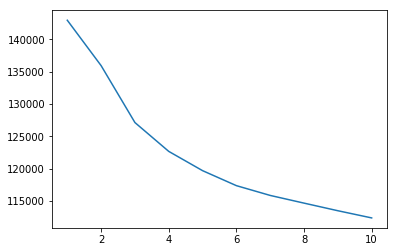

In [112]:
wcss = []
for i in tqdm(range(1,11)):
    kmeans = KMeans(i,init='k-means++')
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)

## Clustering

In [55]:
kmeans = KMeans(6,init='k-means++')
y_kmeans = kmeans.fit_predict(features)

In [91]:
dict_time = {}

In [92]:
unique,counts = np.unique(y_kmeans,return_counts=True)
dict_time = dict(zip(unique,counts))

In [93]:
dict_time

{0: 291, 1: 296, 2: 371, 3: 15, 4: 427, 5: 343}

## SVM

In [ ]:
t_j = 0
j = 0
x_svm = []
y_svm = []
for subdirs,dirs,files in os.walk(data_folder+'dev-clean/Spectrograms'):
    t_j+=1
for subdirs,dirs,files in os.walk(data_folder+'dev-clean/Spectrograms'):
    for file in files:
        if file.endswith('.png'):
            image = cv2.imread(subdirs+'/'+file)
            image = cv2.resize(image,(im_size,im_size))
            image = np.expand_dims(image,axis=0)
            x_svm.append(model2.predict(image))
            y_svm.append(dict_y.get(int(subdirs.split('/')[-1][:-4])))
    j+=1
#     print(float(j)/t_j*100)

In [37]:
x_svm2 = x_svm
y_svm2 = y_svm

In [38]:
x_svm = []
y_svm = []
test_indices = random.sample(range(len(x_svm2)),1000)
for i in test_indices:
    x_svm.append(x_svm2[i])
    y_svm.append(y_svm2[i])

In [39]:
x_svm = np.array(x_svm).reshape(len(x_svm),-1)
y_svm = np.array(y_svm).reshape(len(y_svm),-1)

In [40]:
x_svm.shape

(1000, 65536)

In [42]:
x_svm_train,x_svm_test,y_svm_train,y_svm_test = train_test_split(x_svm,y_svm,test_size=0.2)

In [44]:
sc =  StandardScaler()
x_svm_train = sc.fit_transform(x_svm_train)
x_svm_test = sc.transform(x_svm_test)

In [46]:
svm = SVC(kernel='rbf')

In [47]:
svm.fit(x_svm_train,y_svm_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
y_svm_pred = svm.predict(x_svm_test)

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
cm = confusion_matrix(y_svm_test,y_svm_pred)

In [51]:
cm

array([[67, 35],
       [34, 64]])

In [52]:
y_svm_pred = svm.predict(features)

In [76]:
y_svm_pred.shape

(1743,)

In [56]:
print(y_svm_pred,y_kmeans)

[0 0 0 ... 0 0 0] [3 3 3 ... 3 3 3]


In [89]:
dict_gender = {}
for i in range(6):
    for j in range(len(y_kmeans)):
        c1 = 0
        c2 = 0
        if(y_kmeans[j]==i):
            c1 += 1
            c2 += y_svm_pred[i]
        if(c1!=0):
            dict_gender[i] = 1 if(float(c2)/c1>0.5) else 0
            

In [ ]:
dict_gender

In [94]:
dict_time

{0: 291, 1: 296, 2: 371, 3: 15, 4: 427, 5: 343}